# Tu Nombre: Oscar Esau Peralta Rosales
## Procesamiento de Lenguaje Natural
## Tarea 2: Análisis Semántico y Selección de Carácteristicas

### Lectura simple de datos

In [1]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics, preprocessing
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from wordcloud import WordCloud



%matplotlib inline

from keras.preprocessing.text import Tokenizer


def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for twitt in f_corpus:
            tr_txt += [twitt]
        for label in f_truth:
            tr_y += [label]        
    return tr_txt, tr_y



Using TensorFlow backend.


In [0]:
tr_txt, tr_y = get_texts_from_file("./mex_train.txt", "./mex_train_labels.txt")

### Estadisticas Simples

In [3]:
tr_y = np.array(list(map(int, tr_y)))
print(tr_y.shape)

(5544,)


Counter({0: 3563, 1: 1981})


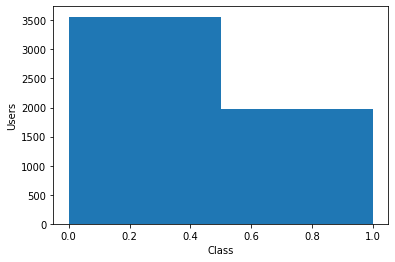

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_y))
plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel('Users');
plt.xlabel('Class');

# Un ojo a los datos

In [5]:
tr_txt[:10]

['lo peor de todo es que no me dan por un tiempo y luego vuelven estoy hasta la verga de estl\n',
 'a la vga no seas mamón 45 putos minutos después me dices que apenas sales no me querías avisar en 3 horas? 😑\n',
 'considero que lo más conveniente seria que lo retes a unos vergazos mi jelipe! rómpele la madre a ese pinchi joto!\n',
 'el marica de mi ex me tiene bloqueada de todo así  uno no puede admirar la "belleza" de su garnacha 😂\n',
 'mujer despechadaya pinche amlo hazle esta que se pela la loca #reynosafollow #reynosa\n',
 'putos. no tienen madre. ambriados mantenidos. ojetes. como es posible. mejor matarlos\n',
 'ustedes si puden andar de chanceros pero cuidadito y seamos nosotras porque luego luego empiezan a mamar hijos de la chingada.\n',
 '@usuario jajjaja te digo esa madre si está buena ajjaja\n',
 'odio los putos trámites de titulación 😡😡😡😡😡😡😡😡😡😡😡 pero me urge la precedula.\n',
 '@usuario no te equivocabas mi madre y tu tenían muchísima razón siempre es mejor lo que viene 

### Construcción simple del vocabulario

In [0]:
import nltk

In [0]:
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += doc.split()
#print(corpus_palabras)
fdist = nltk.FreqDist(corpus_palabras)

In [8]:
fdist

FreqDist({'de': 3342, 'que': 3336, 'a': 2605, 'la': 2417, 'y': 2225, 'no': 1743, 'me': 1582, 'el': 1285, '@usuario': 1243, 'en': 1184, ...})

In [9]:
len(fdist)

17055

In [0]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [0]:
V = sortFreqDict(fdist)
V = V[:5000]

In [0]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1   

### Bolsa de Términos

In [0]:
import numpy as np
def build_bow_tr(tr_txt, V, dict_indices):
    BOW = np.zeros((len(tr_txt),len(V)), dtype=float)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tr.split())
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
        cont_doc += 1
        
    return BOW

### Debug?

In [14]:
tr_txt[10]

'"no me importa lo que digan esos putos periodistas la puta que los pario oh oh oh hay que alentar a la selección"\n'

In [0]:

fdist_doc = nltk.FreqDist(tr_txt[10].split())

In [16]:
fdist_doc

FreqDist({'que': 3, 'oh': 3, 'la': 2, '"no': 1, 'me': 1, 'importa': 1, 'lo': 1, 'digan': 1, 'esos': 1, 'putos': 1, ...})

### Bolsa de Terminos en Validación

In [0]:
BOW_tr=build_bow_tr(tr_txt, V, dict_indices)

In [18]:
print(V[:10])

[(3342, 'de'), (3336, 'que'), (2605, 'a'), (2417, 'la'), (2225, 'y'), (1743, 'no'), (1582, 'me'), (1285, 'el'), (1243, '@usuario'), (1184, 'en')]


In [0]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
#print(BOW[10])

In [0]:
val_txt, val_y = get_texts_from_file("./mex_val.txt", "./mex_val_labels.txt")

In [0]:
val_y = np.array(list(map(int, val_y)))

Counter({0: 397, 1: 219})


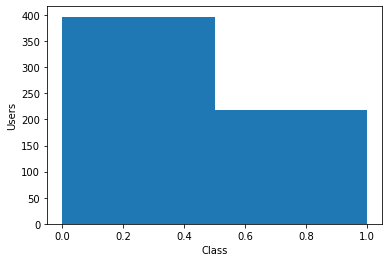

In [22]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(val_y))
plt.hist(val_y, bins=len(set(val_y)))
plt.ylabel('Users');
plt.xlabel('Class');

In [23]:
val_txt[:10]

['así debería ser siempre para que se mueran a la verga\n',
 'cada día me siento como un perro ovejero tratando de cuidar sus ovejas vale madre pinches rateros póngase a trabajar.😤\n',
 'hijo de tu puta madre nadamas te la pasas mamando pinche wilo de closet\n',
 'soñé horrible espero no se cumpla putos temblores.\n',
 '@usuario mejor vas y la chingas tú veo tus publicaciones y solo denotan inconformidad como típico ciudadano quejumbroso que no hace nada por cambiar\n',
 'y quizás este loca y quizás me guste estarlo... #siempreneruda\n',
 'me tienen hasta la verga con sus putos #boomerang pendejos y sin sentido.\n',
 'cuando va a ser el día que encuentre a alguien en quien pueda  confiar posts la re puta madre?\n',
 '#ahoritaestoypensando  como putas puede pasar esto?\n',
 '#todoibabienpero valio madre ya me atacó el insomnio🙅\n']

In [0]:
BOW_val=build_bow_tr(val_txt, V, dict_indices)

In [25]:
BOW_tr.shape

(5544, 5000)

# 1) Utilizando la matriz BOW_tr lleve acabo la descomposición de valores sigulares.

In [0]:
# In paper (row, col) => (ter, doc)
# so we will use BOW_tr.T

U, S, V = np.linalg.svd(BOW_tr.T, full_matrices=False)

## 1.2) Imprima los tamaños de las matrices obtenidas con SVD

In [27]:
U.shape, S.shape, V.shape

((5000, 5000), (5000,), (5000, 5544))

## 1.3) Imprima la matriz sigma en su versión cuadrada unicamente con el top 10 de valores en la diagonal.

In [0]:
k = 10

Sk = np.zeros((k, k), dtype=float)

np.fill_diagonal(Sk, S[:k])

In [29]:
print(Sk)

[[121.46389317   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          59.92000745   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          56.09662232   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          50.25544863   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          47.70062991
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   46.87218396   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.          42.00630312   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.          41.69911538   0

## 1.4) Los primeros 10x10 elementos de la matriz original de BOW_tr con los primeros 10x10 valores de su versión reconstruida a través de el top 10 de valores en sigma

In [30]:
Uk = U[:,range(k)]
Uk.shape

(5000, 10)

In [31]:
Vk = V[range(k), :]
Vk.shape

(10, 5544)

In [32]:
Ck = Uk @ Sk @ Vk
Ck.shape

(5000, 5544)

In [33]:
print(Ck.T[np.ix_(range(k),range(k))])

[[ 1.97021140e+00  1.12541808e+00 -9.43645336e-02  1.11795275e+00
   1.07693990e+00  9.92386479e-01  9.86544743e-01  1.43236767e-01
  -1.94162008e-02 -4.56513189e-02]
 [-9.37618241e-02  8.61648257e-01  8.69493748e-01  8.98811028e-01
  -1.67713223e-01  1.74022386e+00  1.86966367e+00  2.67702265e-02
  -3.35757424e-03  6.16159714e-01]
 [ 2.57575850e-02  2.08103410e+00  2.02490204e+00  9.33178327e-01
   6.13528269e-02 -5.40978781e-02  1.67134247e-01 -3.81181693e-02
   1.94898142e-01 -1.13872802e-01]
 [ 2.95887815e+00 -4.30659486e-02  3.20947808e-02  8.12284267e-01
  -4.02072580e-02  8.39671714e-01  9.98306716e-01  7.22384592e-01
   2.63151750e-02  2.97345162e-01]
 [ 1.04347724e-02  1.02591440e+00  9.97311237e-03  9.96768052e-01
   1.93428853e-02  5.53177879e-02  4.15207404e-03  1.20424652e-03
  -8.05442816e-03  2.00430569e-01]
 [ 8.00419554e-03  6.84199237e-02 -3.85944752e-02  4.69449446e-02
   3.14373343e-02  1.06979555e+00 -3.25980268e-02  1.66657917e-01
   7.47249088e-02 -5.98306273e-02

In [34]:
print(BOW_tr[np.ix_(range(k),range(k))])

[[2. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 2. 2. 0. 0. 1.]
 [0. 2. 2. 1. 0. 0. 0. 0. 0. 0.]
 [3. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [2. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]]


## 1.5) Proyecte todos los documentos en BOW_val al espacio latente obtenido con LSI

In [0]:
proy_k = np.linalg.inv(Sk) @ Uk.T

In [36]:
proy_k.shape, BOW_tr.shape

((10, 5000), (5544, 5000))

In [0]:
BOW_tr_proy = proy_k @ BOW_tr.T

In [38]:
BOW_tr_proy.shape

(10, 5544)

## 1.6) Evalué 1.5 en clasificación supervisada

In [0]:
def classify(x_train, y_train, x_val, y_val, kbest=None):
    """ Clasificación con SVM, feature selection with chi2 """
    parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}
    
    if kbest:
        selectk = SelectKBest(chi2, k=kbest)
        selectk.fit(x_train, y_train)
        x_train = selectk.transform(x_train)
        x_val = selectk.transform(x_val)
    
    svr = svm.LinearSVC(class_weight='balanced')
    grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=5)
    
    grid.fit(x_train, y_train) 

    y_pred = grid.predict(x_val)

    p, r, f, _ = precision_recall_fscore_support(y_val, y_pred, average='macro', pos_label=None)
    a = accuracy_score(y_val, y_pred)
    print(confusion_matrix(y_val, y_pred) )
    print(metrics.classification_report(y_val, y_pred))
    return p, r , f, a

In [0]:
x_train = BOW_tr_proy.T
y_train = np.array(tr_y)

In [41]:
x_train.shape

(5544, 10)

In [0]:
# make the same proyection over the validation data
x_val = (proy_k @ BOW_val.T).T
y_val = val_y

In [43]:
x_val.shape

(616, 10)

In [44]:
_, _, _, _ = classify(x_train, y_train, x_val, y_val)

[[260 137]
 [ 93 126]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       397
           1       0.48      0.58      0.52       219

    accuracy                           0.63       616
   macro avg       0.61      0.62      0.61       616
weighted avg       0.65      0.63      0.63       616



## 1.7) Vuelva a construir LSI pero ahora sobre una matriz tf-idf normalizada con l2, posteriormente evalué y compare en clasificación supervisada.

In [0]:
def build_tfidf_bow(bows, normalize=False):
    """ Build a tfidf bow """
    # Compute count of terms aparitions on documents
    bows = bows.copy()
    ndocs_terms = np.sum(bows > 0, axis=0)
    zeros = np.where(ndocs_terms == 0)[0]
    ndocs_terms[zeros] = 1 # Replace for 1 to avoid math error
    
    for index, bow in enumerate(bows):
        # compute tf
        n_terms = np.sum(bow > 0)
        tf = bows[index] / (n_terms if n_terms else 1.0)
        # compute tf*idf
        idf  = (np.log(bows.shape[0] / ndocs_terms))
        idf[zeros] = 0.0

        bows[index] = tf * idf

        if normalize:
            norm = np.linalg.norm(bows[index])
            bows[index] = bows[index] / (norm if norm else 1.0)
    return bows

In [0]:
# In paper (row, col) => (ter, doc)
# so we will use BOW_tr.T

BOW_tfidf = build_tfidf_bow(BOW_tr, normalize=True)

In [0]:
U, S, V = np.linalg.svd(BOW_tfidf.T, full_matrices=False)

In [0]:
# Select k-range
k = 10

Sk = np.zeros((k, k), dtype=float)
np.fill_diagonal(Sk, S[:k])

Uk = U[:,range(k)]
Vk = V[range(k), :]


# Make protection matrix
proy_k = np.linalg.inv(Sk) @ Uk.T

In [49]:
# Train
x_train = (proy_k @ BOW_tfidf.T).T
y_train = tr_y

# Validation
BOW_val_tfidf = build_tfidf_bow(BOW_val, normalize=True)
x_val = (proy_k @ BOW_val_tfidf.T).T
y_val = val_y

_, _, _, _ = classify(x_train, y_train, x_val, y_val)

[[265 132]
 [ 78 141]]
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       397
           1       0.52      0.64      0.57       219

    accuracy                           0.66       616
   macro avg       0.64      0.66      0.64       616
weighted avg       0.68      0.66      0.67       616



# 2)  Calcule Información mutua para los términos de la matriz BOW_tr e imprima el top 50 de cada clase (Visualice TAMBIEN CON https://amueller.github.io/word_cloud/)

In [0]:
# Number of docs that contain ki and are classified in cp

def get_nt(x_train):
    """ number of documents """
    return x_train.shape[0]

def get_ni_vec(x_train):
    """ Docs that contain the term k_i """
    return np.sum(x_train > 0, axis=0)

def get_np_dict(y_train):
    """ Total number of training docs in class cp """
    return nltk.FreqDist(y_train)


def get_nip_dic_vec(x_train, y_train, clases):
    """  # docs that contain term k_i and are classified in cp """
    ans = {}
    for ci in clases:
        class_match = np.array(y_train) == ci
        docs_ci = x_train[class_match, :]
        ans[ci] = np.sum(docs_ci > 0, axis=0)
    return ans


def mutual_information(x_train, y_train, dict_indices):
    _nt = get_nt(x_train)
    _ni = get_ni_vec(x_train)
    _np = get_np_dict(y_train)
    _clases = _np.keys()
    _nip = get_nip_dic_vec(x_train, y_train, _clases)

    mi_count = np.zeros(x_train.shape[1], dtype=float)

    for _ci in _clases:
        ans1 = _np[_ci] / _nt
        ans2 = _nip[_ci] / (_ni * _np[_ci])
        ans2[ans2==0] = 1
        mi_count = mi_count + ans1 * np.log(ans2)
    mi = {word: mi_count[index] for word, index in dict_indices.items() }

    return mi



In [0]:
mi = mutual_information(BOW_tr, y_train, dict_indices)

In [52]:
srtd = sorted(mi.items(), key=lambda item: item[1], reverse=True)

for key, value in srtd[:50]:
    print(key, value)

hdp. -2.712568237646073
bola -2.712568237646073
lameculos -2.712568237646073
corruptos -2.712568237646073
rateros -2.712568237646073
culeros -2.712568237646073
chilenos -2.712568237646073
t -2.712568237646073
mediocre -2.712568237646073
holanda -2.712568237646073
pedazo -2.712568237646073
hdp!! -2.712568237646073
simios -2.712568237646073
reputa -2.712568237646073
zorras -2.712568237646073
vayanse -2.712568237646073
ratero -2.712568237646073
puta. -2.712568237646073
pario -2.712568237646073
maricones -2.712568237646073
jotos -2.712568237646073
60 -2.712568237646073
santas -2.712568237646073
robaron -2.712568237646073
primaria -2.712568237646073
priistas -2.712568237646073
orgullo -2.712568237646073
nacos -2.712568237646073
merecen -2.712568237646073
lame -2.712568237646073
juegan -2.712568237646073
humano -2.712568237646073
huevos. -2.712568237646073
culito -2.712568237646073
#rusia2018 -2.712568237646073
#méxico -2.712568237646073
éstos -2.712568237646073
vengas -2.712568237646073
tra

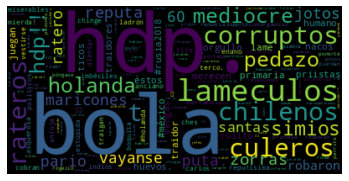

In [53]:
wc = WordCloud()
wc.generate_from_frequencies(mi)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

# 3)  Calcule ganancia de información para los términos de la matriz BOW_tr e imprima el top 50 de la colección y su ganancia. (Visualice TAMBIEN CON https://amueller.github.io/word_cloud/)

In [0]:
def information_gain(x_train, y_train, dict_indices):
    _nt = get_nt(x_train)
    _ni = get_ni_vec(x_train)
    _np = get_np_dict(y_train)
    _clases = _np.keys()
    _nip = get_nip_dic_vec(x_train, y_train, _clases)

    ig_count = np.zeros(x_train.shape[1], dtype=float)

    for _ci in _clases:

        nip_zeros = _nip[_ci] == 0
        _nip[_ci][nip_zeros] = 1

        t1 = (_np[_ci] / _nt) * np.log(_np[_ci] / _nt)
        
        t2_1 = - (_nip[_ci] / _nt)
        t2_2 = np.log(_nip[_ci] / _ni)
        t2_2[nip_zeros] = 0

        t3_1 = - (_np[_ci] - _nip[_ci]) / _nt
        t3_2 = np.log((_np[_ci] - _nip[_ci]) / (_nt - _ni))

        ans = t1 + t2_1*t2_2 + t3_1*t3_2

        ig_count = ig_count - ans

    ig = {word: ig_count[index] for word, index in dict_indices.items() }

    return ig

In [0]:
ig = information_gain(BOW_tr, y_train, dict_indices)

In [56]:
srtd = sorted(ig.items(), key=lambda item: item[1], reverse=True)

for key, value in srtd[:50]:
    print(key, value)

loca 0.028852189508744852
@usuario 0.024133027555542613
hdp 0.02147132070467528
putos 0.012438984742709963
me 0.011020948560330174
tu 0.00895112072655646
hijos 0.008011748037846933
pendejo 0.007176139350027644
estoy 0.006843296690250966
hijo 0.006819879285694885
son 0.006758438872341677
pendejos 0.006717490977608653
puto 0.006716516891637547
puta 0.006322873488983194
chinguen 0.006153021888585242
mi 0.005571121349737362
pinche 0.005401702904731132
mamar 0.005255902443790594
mierda 0.00515185698625642
los 0.005008146471450037
chingas 0.004729693149022385
chinga 0.004521408485260392
su 0.004043081201705712
mundial 0.003963813564397289
pinches 0.003961558525654552
chingar 0.00391750952899711
a 0.003805776292428953
esos 0.0037214664639331763
hdp. 0.0036230360167875952
bola 0.0036230360167875952
vida 0.0034650674872461207
lameculos 0.003436293185526351
mil 0.0033480346821804785
esta 0.0029598197359347322
soy 0.0029271865711535394
hondureños 0.002900507584856382
verga 0.0028110162106015912
v

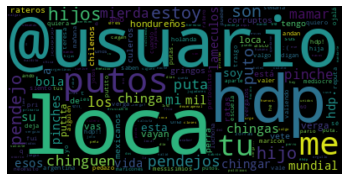

In [57]:
wc = WordCloud()
wc.generate_from_frequencies(ig)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

# 4)  Calcule ganancia de información con Chi2 para los términos de la matriz BOW_tr e imprima el top 50 de la colección y su ganancia. (Visualice TAMBIEN CON https://amueller.github.io/word_cloud/)

In [0]:
def chi_2(x_train, y_train, dict_indices, average=True):
    _nt = get_nt(x_train)
    _ni = get_ni_vec(x_train)
    _np = get_np_dict(y_train)
    _clases = _np.keys()
    _nip = get_nip_dic_vec(x_train, y_train, _clases)

    chi_count = np.zeros(x_train.shape[1], dtype=float)

    def _chi_2(_ci):
        a1 =  _nt * (_nt * _nip[_ci] - _np[_ci] * _ni)**2
        a2 = _np[_ci] * _ni * (_nt - _np[_ci]) * (_nt - _ni)
        return a1 / a2

    for _ci in _clases:
        ans = _chi_2(_ci)
        if average:
            chi_count = chi_count + ans * _np[_ci] / _nt
        else:
            chi_count = np.maximum(chi_count, ans)


    chi = {word: chi_count[index] for word, index in dict_indices.items() }

    return chi

In [0]:
c2 = chi_2(BOW_tr, y_train, dict_indices)

In [60]:
srtd = sorted(c2.items(), key=lambda item: item[1], reverse=True)

for key, value in srtd[:50]:
    print(key, value)

@usuario 279.4731212724867
hdp 234.76429396278553
loca 230.41190413370444
putos 144.0104427629667
me 116.17102429809711
tu 104.17983846701694
hijos 91.92987168045377
pendejo 81.49875059182583
son 79.10560456676558
hijo 78.60426429643704
puto 78.39932410699016
puta 73.94419700049156
pendejos 70.70301121143663
estoy 63.51560834624853
chinguen 63.29756857773697
pinche 63.013947673852726
mierda 60.0746922879338
mamar 59.00306255011856
mi 57.8023589522864
los 57.307273436560656
chingas 53.80505993774573
chinga 49.89366112378983
su 46.53325515866597
pinches 46.394827453094294
mundial 45.355437734360734
chingar 45.20891413781957
esos 43.58369150754647
a 42.554995492664965
mil 38.7830231189253
hdp. 36.10196943373343
bola 36.10196943373343
lameculos 34.29066338359209
vida 32.070516992977716
vas 31.90693526974166
hondureños 30.70304859816075
putita 30.657305313145983
verga 30.14055276184603
esta 29.337688040824965
soy 28.35659444074517
vayan 25.74116223742184
vete 23.97772674898274
gringos 23.52

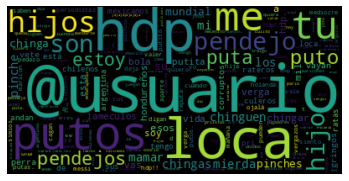

In [61]:
wc = WordCloud()
wc.generate_from_frequencies(c2)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()